# Example of analysis of WLD and DM outputs

In this notebook we are going to show an example of a typical analysis that compares the WLD outputs and the DM-stack outputs. We are going to do this avoiding the use of the LSST DM stack since this is going to be the most probable user case so we are going to use `fistio` and/or `astropy` to read the products of both WLD and DM (disclaimer: this is a not DM-endorsed way to open/use DM products!).

The typical analysis will usually have the following steps:

 * Read data
 * Match input/truth (WLD) and output/processed (DM) catalogs.
 * Plot some quantities of interest.

Let's get started

In [2]:
%pylab inline #this ipython/jupyter magic loads numpy/matplotlib and shows the plots inline

Populating the interactive namespace from numpy and matplotlib


## Data inputs

We import some useful modules to read the data

In [3]:
import astropy.table
import fitsio
try:
    import descwl
    wld_installed=True
except:
    print('Cannot import descwl')
    wld_installed=False
import os
from sklearn.neighbors import KDTree

If you have access to NERSC try to use the pre-generated data hosted in the following directory:

In [4]:
btf_dir = '/global/projecta/projectdirs/lsst/groups/WL/projects/wl-btf'

The file `/global/projecta/projectdirs/lsst/groups/WL/projects/wl-btf/LSST_i_lite.fits` contains an image of the simulated data (noiseless) and the WLD catalog output. You can find more information about the outputs [here](http://weaklensingdeblending.readthedocs.io/en/latest/output.html). This file contains data that corresponds to a LSST i-band image to 10-year depth (5520 s exposure time -- 184 $\times$ 30) for a single chip. The simulation also analyzes the overlap with objects out of the field of view. These objects can be avoided if we select those where the column `visible` is `True`.

The first HDU contains the image data

In [6]:
truth_image = fitsio.read(os.path.join(btf_dir,'LSST_i_lite.fits'),ext=0)

The second HDU contains the output table

In [5]:
truth_table = fitsio.read(os.path.join(btf_dir,'LSST_i_lite.fits'),ext=1)

We can show the noiseless image with `plt.imshow()`

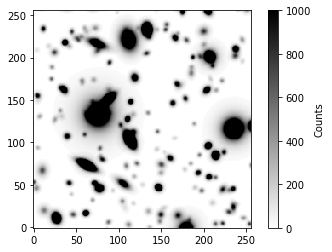

In [7]:
#Let's check the noiseless image (I only show a fraction of it because the 4096 x 4096 image is heavy to render)
plt.imshow(truth_image[0:256,0:256],cmap='gray_r',vmax=1000,origin='lower')
plt.colorbar(label='Counts')

And also check the fields in the table read with `fitsio` (if read with astropy you can just use `truth_table.keys()`)

In [8]:
truth_table.dtype.fields

mappingproxy({'a': (dtype('>f4'), 86),
              'ab_mag': (dtype('>f4'), 58),
              'b': (dtype('>f4'), 90),
              'beta': (dtype('>f4'), 94),
              'db_id': (dtype('>i8'), 0),
              'dg1': (dtype('>f4'), 130),
              'dg1_grp': (dtype('>f4'), 142),
              'dg2': (dtype('>f4'), 134),
              'dg2_grp': (dtype('>f4'), 146),
              'ds': (dtype('>f4'), 126),
              'ds_grp': (dtype('>f4'), 138),
              'dx': (dtype('>f4'), 46),
              'dy': (dtype('>f4'), 50),
              'e1': (dtype('>f4'), 78),
              'e2': (dtype('>f4'), 82),
              'f_bulge': (dtype('>f4'), 42),
              'f_disk': (dtype('>f4'), 38),
              'flux': (dtype('>f4'), 66),
              'g1_fit': (dtype('>f4'), 162),
              'g2_fit': (dtype('>f4'), 166),
              'grp_id': (dtype('>i8'), 8),
              'grp_rank': (dtype('>i2'), 18),
              'grp_size': (dtype('>i2'), 16),
              'h

We now read and show the output of the DM stack. You can get more information about the columns if you use the `Butler` or check the `Process.ipynb` file in this repository.

In [9]:
# For some reason fitsio doesn't recognize this properly...
#dm_table = fitsio.read(os.path.join(btf_dir,'LSST_i_DM.fits.gz'),ext=1)
dm_table = astropy.table.Table.read(os.path.join(btf_dir,'LSST_i_DM.fits.gz'),hdu=1)

In [10]:
dm_table

flags [72],id,coord_ra,coord_dec,parent,deblend_nChild,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psfFlux,base_GaussianCentroid_x,base_GaussianCentroid_y,base_NaiveCentroid_x,base_NaiveCentroid_y,base_SdssCentroid_x,base_SdssCentroid_y,base_SdssCentroid_xSigma,base_SdssCentroid_ySigma,base_Blendedness_old,base_Blendedness_raw_flux,base_Blendedness_raw_flux_child,base_Blendedness_raw_flux_parent,base_Blendedness_abs_flux,base_Blendedness_abs_flux_child,base_Blendedness_abs_flux_parent,base_Blendedness_raw_child_xx,base_Blendedness_raw_child_yy,base_Blendedness_raw_child_xy,base_Blendedness_raw_parent_xx,base_Blendedness_raw_parent_yy,base_Blendedness_raw_parent_xy,base_Blendedness_abs_child_xx,base_Blendedness_abs_child_yy,base_Blendedness_abs_child_xy,base_Blendedness_abs_parent_xx,base_Blendedness_abs_parent_yy,base_Blendedness_abs_parent_xy,base_SdssShape_xx,base_SdssShape_yy,base_SdssShape_xy,base_SdssShape_xxSigma,base_SdssShape_yySigma,base_SdssShape_xySigma,base_SdssShape_x,base_SdssShape_y,base_SdssShape_flux,base_SdssShape_fluxSigma,base_SdssShape_psf_xx,base_SdssShape_psf_yy,base_SdssShape_psf_xy,base_SdssShape_flux_xx_Cov,base_SdssShape_flux_yy_Cov,base_SdssShape_flux_xy_Cov,base_CircularApertureFlux_3_0_flux,base_CircularApertureFlux_3_0_fluxSigma,base_CircularApertureFlux_4_5_flux,base_CircularApertureFlux_4_5_fluxSigma,base_CircularApertureFlux_6_0_flux,base_CircularApertureFlux_6_0_fluxSigma,base_CircularApertureFlux_9_0_flux,base_CircularApertureFlux_9_0_fluxSigma,base_CircularApertureFlux_12_0_flux,base_CircularApertureFlux_12_0_fluxSigma,base_CircularApertureFlux_17_0_flux,base_CircularApertureFlux_17_0_fluxSigma,base_CircularApertureFlux_25_0_flux,base_CircularApertureFlux_25_0_fluxSigma,base_CircularApertureFlux_35_0_flux,base_CircularApertureFlux_35_0_fluxSigma,base_CircularApertureFlux_50_0_flux,base_CircularApertureFlux_50_0_fluxSigma,base_CircularApertureFlux_70_0_flux,base_CircularApertureFlux_70_0_fluxSigma,base_GaussianFlux_flux,base_GaussianFlux_fluxSigma,base_PsfFlux_flux,base_PsfFlux_fluxSigma,base_Variance_value,footprint
,,rad,rad,,,pix,pix,,pix,pix,pix,pix,pix,pix,pix,pix,,,ct,ct,,ct,ct,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix,pix,ct,ct,pix2,pix2,pix2,ct pix2,ct pix2,ct pix2,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,,
bool,int64,float64,float64,int64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32
False .. False,1,6.28128420571,-0.0019356737615,0,0,nan,nan,nan,27.0768598578,11.4383378685,27.0176311249,11.0608926431,27.0,11.0,nan,nan,0.0,0.0,543616.360358,543616.360358,nan,nan,nan,5.24338381124,7.0228386036,-0.591476181352,5.24338381124,7.0228386036,-0.591476181352,nan,nan,nan,nan,nan,nan,5.25971206206,7.0545377877,-0.589759438143,0.0296036,0.0243561,0.0397055,27.0410528232,11.2206074577,550639.486067,1549.59905583,2.92273950734,2.92273950734,-1.17672300434e-08,-22.9368,2.57185,-30.7638,286850.75,527.665100098,436901.4375,655.729370117,522410.90625,721.01171875,581724.5,762.749755859,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,550639.486067,1095.73201426,402845.133849,736.355675167,9.10712432861,1
False .. False,2,6.28143208746,-0.00194124647768,0,2,nan,nan,nan,180.0,6.0,179.845709721,5.90871460977,180.0,6.0,nan,nan,0.0,0.0,250021.211212,250021.211212,nan,nan,nan,8.22149905158,33.1894654805,1.86002904957,8.22149905158,33.1894654805,1.86002904957,nan,nan,nan,nan,nan,nan,6.87758899633,1

The stack returns a table with all detected objects and repeats those that go into the deblending stage. We have to make sure to select only the "final" product. Those objects have the variable `deblend_nChild` with a value equal to zero.

In [11]:
dm_table = dm_table[dm_table['deblend_nChild']==0] # Only fully deblended objects

In [12]:
if wld_installed:
    wld_cat = descwl.output.Reader(os.path.join(btf_dir,'LSST_i_lite.fits')).results
    width,height = wld_cat.survey.image_width,wld_cat.survey.image_height
else:
    height,width = truth_image.shape
pixel_scale = 0.2 # pixel scale in arcseconds
area = height*width*pixel_scale**2/3600.

We employ a nearest neighbors approach using the centroids to match input and output. We obtain the indices `ind` of the truth catalog that are closest to a detected object

In [13]:
def match(catalog,truth,width,height):
    X = np.zeros((len(catalog),2))  
    X[:,0] = catalog['base_SdssCentroid_x']
    X[:,1] = catalog['base_SdssCentroid_y']
    X2 = np.zeros((truth.shape[0],2))
    X2[:,0]=truth['dx']/wld_cat.survey.pixel_scale+0.5*width
    X2[:,1]=truth['dy']/wld_cat.survey.pixel_scale+0.5*height
    tree = KDTree(X2,metric='euclidean')
    #Let's try to match to nearest neighbor for now
    dist, ind = tree.query(X,k=1)
    return dist.flatten(),ind.flatten()

In [14]:
dist, ind = match(dm_table,truth_table,width,height)

We check how many true objects have been assigned more than once to a detected object.

In [15]:
print('Fraction of multiple matches: ',1.0-len(np.unique(ind))/(1.0*len(ind)))

Fraction of multiple matches:  0.000876863334586031


In [16]:
unique_ind, ind_counts = np.unique(ind,return_counts=True)

Note that this matching procedure is pretty simple and that for most applications should be enough. However we just ensure that the objects are close to eachother but we don't specify anything about their flux differences. So some detected objects can be very close to an input and not being that same object (or even being an spurious detection)

# N(z)

A typical example would be to construct the detection efficiency (completeness) as a function of redshift and/or magnitude.

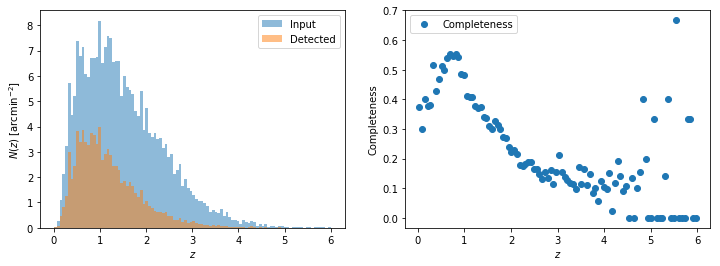

In [17]:
h_in, bin_edges = np.histogram(truth_table['z'],range=(0,6),bins=100)
h_out, bin_edges = np.histogram(truth_table['z'][ind],range=(0,6),bins=100)
f, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].hist(truth_table['z'][truth_table['visible']==True],range=(0,6),bins=100,label='Input',weights=np.ones(np.count_nonzero(truth_table['visible']==True))/area,alpha=0.5)
ax[0].hist(truth_table['z'][ind],range=(0,6),bins=100,weights=np.ones(len(ind))/area,label='Detected',alpha=0.5)
ax[1].plot(0.5*bin_edges[1:]+0.5*bin_edges[:-1],h_out*1.0/h_in,'o', label='Completeness')
for i in range(0,2):
    ax[i].set_xlabel('$z$')
    ax[i].legend(loc='best')
ax[0].set_ylabel('$N(z)$ [arcmin$^{-2}$]')
ax[1].set_ylabel('Completeness');

# N(m)

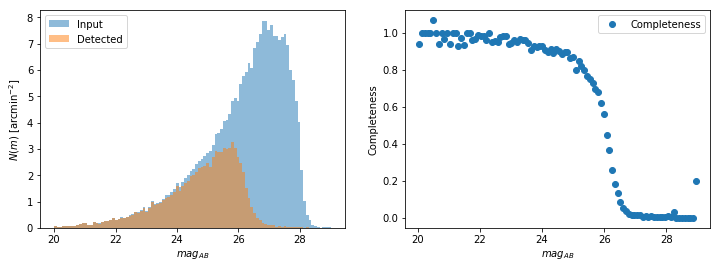

In [18]:
h_in, bin_edges = np.histogram(truth_table['ab_mag'][truth_table['visible']==True],range=(20,29),bins=100)
h_out, bin_edges = np.histogram(truth_table['ab_mag'][ind],range=(20,29),bins=100)
f, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].hist(truth_table['ab_mag'][truth_table['visible']==True],range=(20,29),bins=100,label='Input',weights=np.ones(np.count_nonzero(truth_table['visible']==True))/area,alpha=0.5)
ax[0].hist(truth_table['ab_mag'][ind],range=(20,29),bins=100,label='Detected',weights=np.ones(len(ind))/area,alpha=0.5)
ax[1].plot(0.5*bin_edges[1:]+0.5*bin_edges[:-1],h_out*1.0/h_in,'o',label='Completeness')
for i in range(0,2):
    ax[i].set_xlabel('$mag_{AB}$')
    ax[i].legend(loc='best')
ax[0].set_ylabel('$N(m)$ [arcmin$^{-2}$]')
ax[1].set_ylabel('Completeness');

# Check one of the groups

Another typical use will be check that the inputs and outputs actually match in the image so we are going to check the centroid position for the detected objects and compare it to the input centroids in a blend. This way we can check how many objects the stack has been able to detect and how it deals with heavily blended objects.

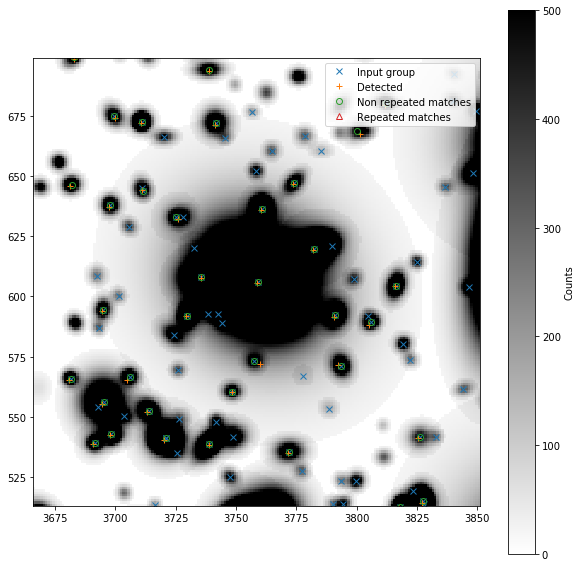

In [19]:
plt.figure(figsize=(10,10))
big_group = np.unique(truth_table['grp_id'][np.argmax(truth_table['grp_size'])]) #Select the ID of the largest group
padding=25
xmin = int(truth_table['xmin'][truth_table['db_id']==big_group])-padding
xmax = int(truth_table['xmax'][truth_table['db_id']==big_group])+padding
ymin = int(truth_table['ymin'][truth_table['db_id']==big_group])-padding
ymax = int(truth_table['ymax'][truth_table['db_id']==big_group])+padding
# Show only the members of the group
xt = truth_table['dx'][truth_table['grp_id']==big_group]/wld_cat.survey.pixel_scale+0.5*wld_cat.survey.image_width
yt = truth_table['dy'][truth_table['grp_id']==big_group]/wld_cat.survey.pixel_scale+0.5*wld_cat.survey.image_height
plt.imshow(truth_image[ymin:ymax,xmin:xmax],origin='lower',cmap='gray_r',vmax=500,extent=[xmin,xmax,ymin,ymax])
plt.plot(xt,yt,'x',label='Input group')
mask = dm_table['deblend_nChild']==0
plt.plot(dm_table['base_SdssCentroid_x'][mask],dm_table['base_SdssCentroid_y'][mask],'+',label='Detected')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
# Show repeated matches
xtt = truth_table['dx'][unique_ind[ind_counts>1]]/wld_cat.survey.pixel_scale+0.5*wld_cat.survey.image_width
ytt = truth_table['dy'][unique_ind[ind_counts>1]]/wld_cat.survey.pixel_scale+0.5*wld_cat.survey.image_height
xttt = truth_table['dx'][unique_ind[ind_counts==1]]/wld_cat.survey.pixel_scale+0.5*wld_cat.survey.image_width
yttt = truth_table['dy'][unique_ind[ind_counts==1]]/wld_cat.survey.pixel_scale+0.5*wld_cat.survey.image_height
plt.plot(xttt,yttt,'o',fillstyle='none',label='Non repeated matches')
plt.plot(xtt,ytt,'^',fillstyle='none',label='Repeated matches')
plt.legend(loc='best')
plt.colorbar(label='Counts');

# Blendedness

From the blending point of view, one interesting variable included in the package is `purity`. This gives us an idea what fraction of the flux an object is receiving from other sources, i.e., it gives us an idea of how blended an object is. In the DM output (default from v14.0+) there's a variable with the same spirit called `base_Blendedness`. One example on how to use these variables can be to check how the stack assigns the flux as a function of the purity/blendedness. Whether this produces any biases or not, etc.

First, let's check the objects that have come from the same "parent"

In [20]:
unique_parents, count_parents = np.unique(dm_table['parent'][dm_table['deblend_nChild']==0],return_counts=True)

Let's select 3 or more object blends.

In [31]:
repeated_parents = unique_parents[count_parents>3]

In [32]:
print(len(repeated_parents))

567


In [33]:
deblended = np.in1d(dm_table['parent'][dm_table['deblend_nChild']==0],repeated_parents)

In [35]:
np.count_nonzero(deblended)

10631

In [36]:
np.count_nonzero(dm_table['deblend_nChild']==0)

15966

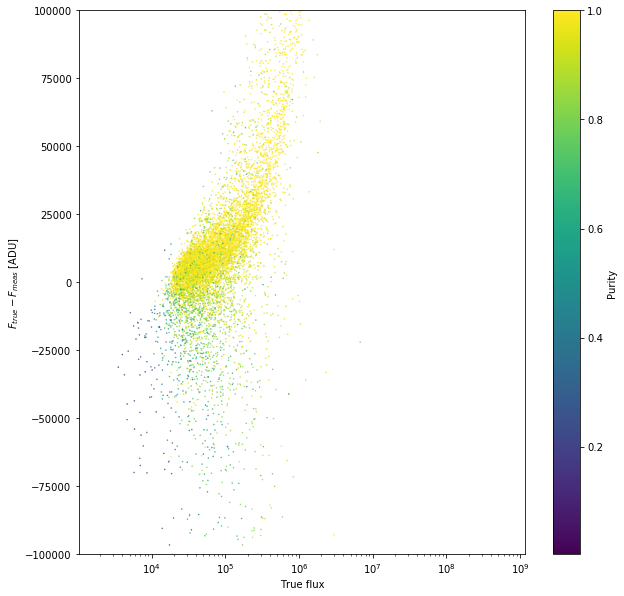

In [65]:
plt.figure(figsize=(10,10))
#plt.scatter(truth_table['flux'][ind],dm_table['base_SdssShape_flux'][dm_table['deblend_nChild']==0],s=0.2)
plt.scatter(truth_table['flux'][ind][deblended],truth_table['flux'][ind][deblended]-dm_table['base_SdssShape_flux'][dm_table['deblend_nChild']==0][deblended],s=0.2,c=truth_table['purity'][ind][deblended])
#plt.plot(np.linspace(1e3,1e9),np.linspace(1e3,1e9),'r--')
plt.xscale('log')
plt.ylim(-1e5,1e5)
plt.colorbar(label='Purity')
plt.xlabel('True flux')
plt.ylabel('$F_{true}-F_{meas}$ [ADU]');

We see that high purity objects tend to "lose" flux to low purity objects.

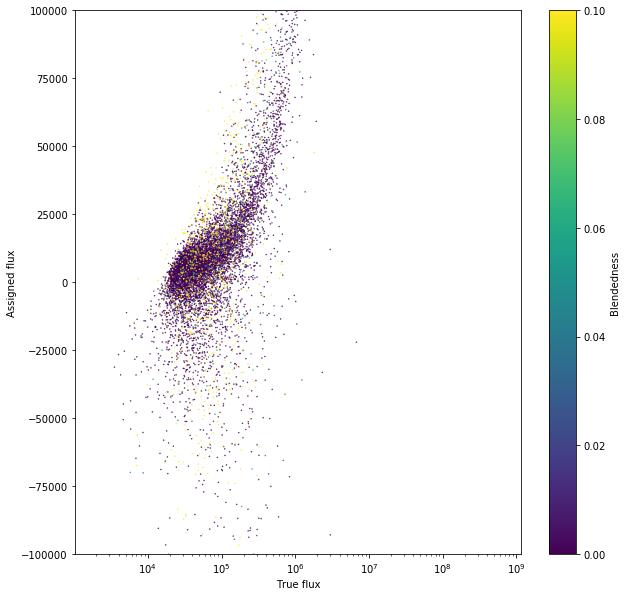

In [68]:
plt.figure(figsize=(10,10))
plt.scatter(truth_table['flux'][ind][deblended],truth_table['flux'][ind][deblended]-dm_table['base_SdssShape_flux'][dm_table['deblend_nChild']==0][deblended],s=0.2,c=dm_table['base_Blendedness_old'][dm_table['deblend_nChild']==0][deblended],vmin=0,vmax=0.1)
plt.xscale('log')
plt.ylim(-1e5,1e5)
plt.colorbar(label='Blendedness')
plt.xlabel('True flux')
plt.ylabel('Assigned flux');